# Quick start
In this tutorial, we will show case main features of scDRS.

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext lab_black

In [2]:
import pandas as pd
import anndata
from anndata import AnnData
import scanpy as sc
from statsmodels.stats.multitest import multipletests

sc.set_figure_params(dpi=150)

import matplotlib.pyplot as plt
from os.path import join

In [3]:
CORTEX_URL = "https://storage.googleapis.com/linnarsson-lab-www-blobs/blobs/cortex/expression_mRNA_17-Aug-2014.txt"
SUPP_TABLE_URL = "https://www.dropbox.com/s/qojbzu5zln33j7f/supp_tables.xlsx?dl=1"

# Compile AnnData dataset

In [4]:
# meta information
df_meta = pd.read_csv(CORTEX_URL, nrows=10, sep="\t", header=None)
df_meta = df_meta.iloc[:, 1:].T
columns = df_meta.iloc[0, :]
df_meta = df_meta.iloc[1:, :]
df_meta.columns = columns
df_meta = df_meta.set_index("cell_id")
df_meta.columns.name = None
df_meta["total mRNA mol"] = df_meta["total mRNA mol"].astype(float)

# expression information
df_expr = pd.read_csv(CORTEX_URL, skiprows=11, sep="\t", header=None).set_index(0)
df_expr.index.name = "gene"
# 1st column in backspin cluster, we don't need it here
df_expr = df_expr.iloc[:, 1:]
df_expr.columns = df_meta.index
df_expr = df_expr.T
raw_adata = AnnData(df_expr, obs=df_meta)

# assemble AnnData
sc.pp.filter_cells(raw_adata, min_genes=0)
sc.pp.filter_genes(raw_adata, min_cells=50)

raw_adata.raw = raw_adata

sc.pp.normalize_total(raw_adata, target_sum=1e4)
sc.pp.log1p(raw_adata)
sc.pp.highly_variable_genes(raw_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

raw_adata = raw_adata[:, raw_adata.var.highly_variable]

sc.pp.scale(raw_adata, max_value=10)
sc.tl.pca(raw_adata, svd_solver="arpack")
sc.pp.neighbors(raw_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(raw_adata)
sc.tl.leiden(raw_adata)

adata = raw_adata.raw.to_adata()
adata.obsp = raw_adata.obsp
adata.X = adata.X.astype(int)

/Users/kangchenghou/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


# use `scDRS` to score cells with disease enrichment

In [6]:
import scdrs

In [7]:
# load gene sets
df_gs = pd.read_excel(SUPP_TABLE_URL, sheet_name="ST6 MAGMA gene sets", index_col=0)
df_gs = df_gs.loc[["PASS_Schizophrenia_Pardinas2018", "UKB_460K.body_HEIGHTz"], :]
df_gs = scdrs.util.convert_gs_species(df_gs)
df_gs = df_gs.rename(
    index={"PASS_Schizophrenia_Pardinas2018": "SCZ", "UKB_460K.body_HEIGHTz": "Height"}
)

In [8]:
# processing
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

# regress out covariates
adata.obs["const"] = 1.0
cov_list = ["const", "n_genes"]
adata.var["mean"] = adata.X.mean(axis=0).T

adata.X -= adata.var["mean"].values
adata.X = scdrs.method.reg_out(adata.X, adata.obs[cov_list].values)
adata.X += adata.var["mean"]
scdrs.method.compute_stats(adata)

In [9]:
dict_df_drs = dict()
for trait in df_gs.index:
    gene_list = df_gs.loc[trait, "GENESET"].split(",")
    gene_list = sorted(set(gene_list) & set(adata.var_names))

    df_drs = scdrs.method.score_cell(
        adata,
        gene_list,
        ctrl_match_key="mean_var",
        n_ctrl=1000,
        return_ctrl_raw_score=False,
        return_ctrl_norm_score=True,
        verbose=False,
    )
    v_fdr = multipletests(df_drs["pval"].values, method="fdr_bh")[1]
    n_rej_01 = (v_fdr < 0.1).sum()
    n_rej_02 = (v_fdr < 0.2).sum()
    print(
        f"Gene set {trait} (n_gene={len(gene_list)}): {n_rej_01}/{df_drs.shape[0]} FDR<0.1 cells, {n_rej_02}/{df_drs.shape[0]} FDR<0.2 cells"
    )

    dict_df_drs[trait] = df_drs

Gene set SCZ (n_gene=756): 177/3005 FDR<0.1 cells, 302/3005 FDR<0.2 cells
Gene set Height (n_gene=671): 0/3005 FDR<0.1 cells, 10/3005 FDR<0.2 cells


# Downstream analyses

... storing 'tissue' as categorical
... storing 'group #' as categorical
... storing 'well' as categorical
... storing 'sex' as categorical
... storing 'age' as categorical
... storing 'diameter' as categorical
... storing 'level1class' as categorical
... storing 'level2class' as categorical
... storing 'mean_var' as categorical


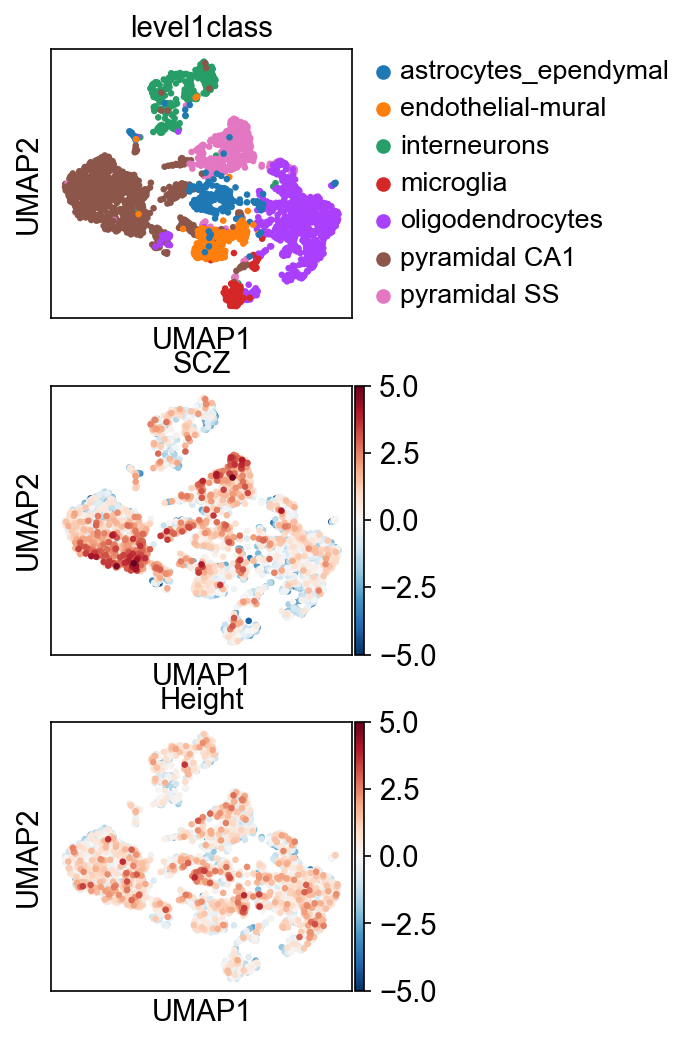

In [10]:
for trait in dict_df_drs:
    adata.obs[trait] = dict_df_drs[trait]["norm_score"]

sc.set_figure_params(figsize=[2, 2.5], dpi=150)
sc.pl.umap(
    adata,
    color=["level1class"] + list(dict_df_drs.keys()),
    ncols=1,
    color_map="RdBu_r",
    vmin=-5,
    vmax=5,
)

/Users/kangchenghou/work/scDRS/scdrs/util.py:490: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/kangchenghou/work/scDRS/scdrs/util.py:490: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


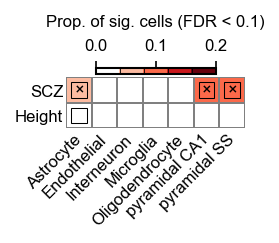

In [11]:
dict_celltype_display_name = {
    "pyramidal_CA1": "Pyramidal CA1",
    "oligodendrocytes": "Oligodendrocyte",
    "pyramidal_SS": "Pyramidal SS",
    "interneurons": "Interneuron",
    "endothelial-mural": "Endothelial",
    "astrocytes_ependymal": "Astrocyte",
    "microglia": "Microglia",
}

dict_df_stats = dict()
for trait in dict_df_drs:
    dict_df_stats[trait] = scdrs.util.group_stats(
        dict_df_drs[trait], adata, group_col="level1class"
    )

scdrs.util.plot_group_stats(
    {
        trait: df_stats.rename(index=dict_celltype_display_name)
        for trait, df_stats in dict_df_stats.items()
    }
)

# Alternatively, use command line interface

In [12]:
# adata.write_h5ad("data/expression.h5ad")
# df_cov.to_csv("data/cov.tsv", sep="\t")
# df_gs.reset_index().to_csv("data/geneset.gs", sep="\t")

```shell
python ../../compute_score.py \
    --h5ad_file data/expression.h5ad \
    --h5ad_species mouse \
    --gs_file data/geneset.gs \
    --gs_species human \
    --cov_file data/cov.tsv \
    --flag_filter True \
    --flag_raw_count True \
    --flag_return_ctrl_raw_score False \
    --flag_return_ctrl_norm_score True \
    --out_folder data/

for trait in PASS_Schizophrenia_Pardinas2018 UKB_460K.body_HEIGHTz; do
    python ../../compute_downstream.py \
        --h5ad_file data/expression.h5ad \
        --score_file data/${trait}.full_score.gz \
        --cell_type level1class \
        --flag_gene True \
        --flag_filter True \
        --flag_raw_count True \
        --out_folder data/
done
```

In [13]:
# for trait in df_gs.index.values:
#     df_score = pd.read_csv(f"data/{trait}.score.gz", sep='\t', index_col=0)
#     adata.obs[trait] = df_score["norm_score"].reindex(adata.obs.index)